#### Import everthing needed

In [1]:
#import tensorflow and sklearn stuff
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_curve, auc
from keras.utils.vis_utils import plot_model

#import models
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16

#### function for training in batches

In [2]:

def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     train_path = os.path.join(base_dir, 'train+val', 'train')
     valid_path = os.path.join(base_dir, 'train+val', 'valid')

     # instantiate data generators
     datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

     train_gen = datagen.flow_from_directory(train_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary', shuffle=False)

     val_gen = datagen.flow_from_directory(valid_path,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary', shuffle=False)

     return train_gen, val_gen

#### define image size

In [3]:
IMAGE_SIZE = 96

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

model_input = Input(input_shape)

#### load models with weights

In [4]:
pretrained_ResNet = ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')
pretrained_EfficientNet = EfficientNetB5(input_shape=input_shape, include_top=False, weights='imagenet')
pretrained_VGG = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
pretrained_Xception = Xception(input_shape=input_shape, include_top=False, weights='imagenet')


## creating average ensemble

In [5]:
#average ensemble
models = [pretrained_ResNet, pretrained_EfficientNet, pretrained_VGG, pretrained_Xception]
model_outputs = [Dense(1, activation = 'sigmoid')(Dropout(0.5)(GlobalAveragePooling2D()(model(model_input)))) for model in models]
ensemble_average_output = tf.keras.layers.Average()(model_outputs)
ensemble_average_model = Model(inputs=model_input, outputs=ensemble_average_output)

ensemble_average_model.compile(SGD(lr=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])
ensemble_average_model.summary()

# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20192236\Documents\Project_Imaging')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 resnet152v2 (Functional)       (None, 3, 3, 2048)   58331648    ['input_1[0][0]']                
                                                                                                  
 efficientnetb5 (Functional)    (None, 3, 3, 2048)   28513527    ['input_1[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 3, 3, 512)    14714688    ['input_1[0][0]']                
                                                                                              

C:\Users\20192236\Anaconda3\envs\8p361\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


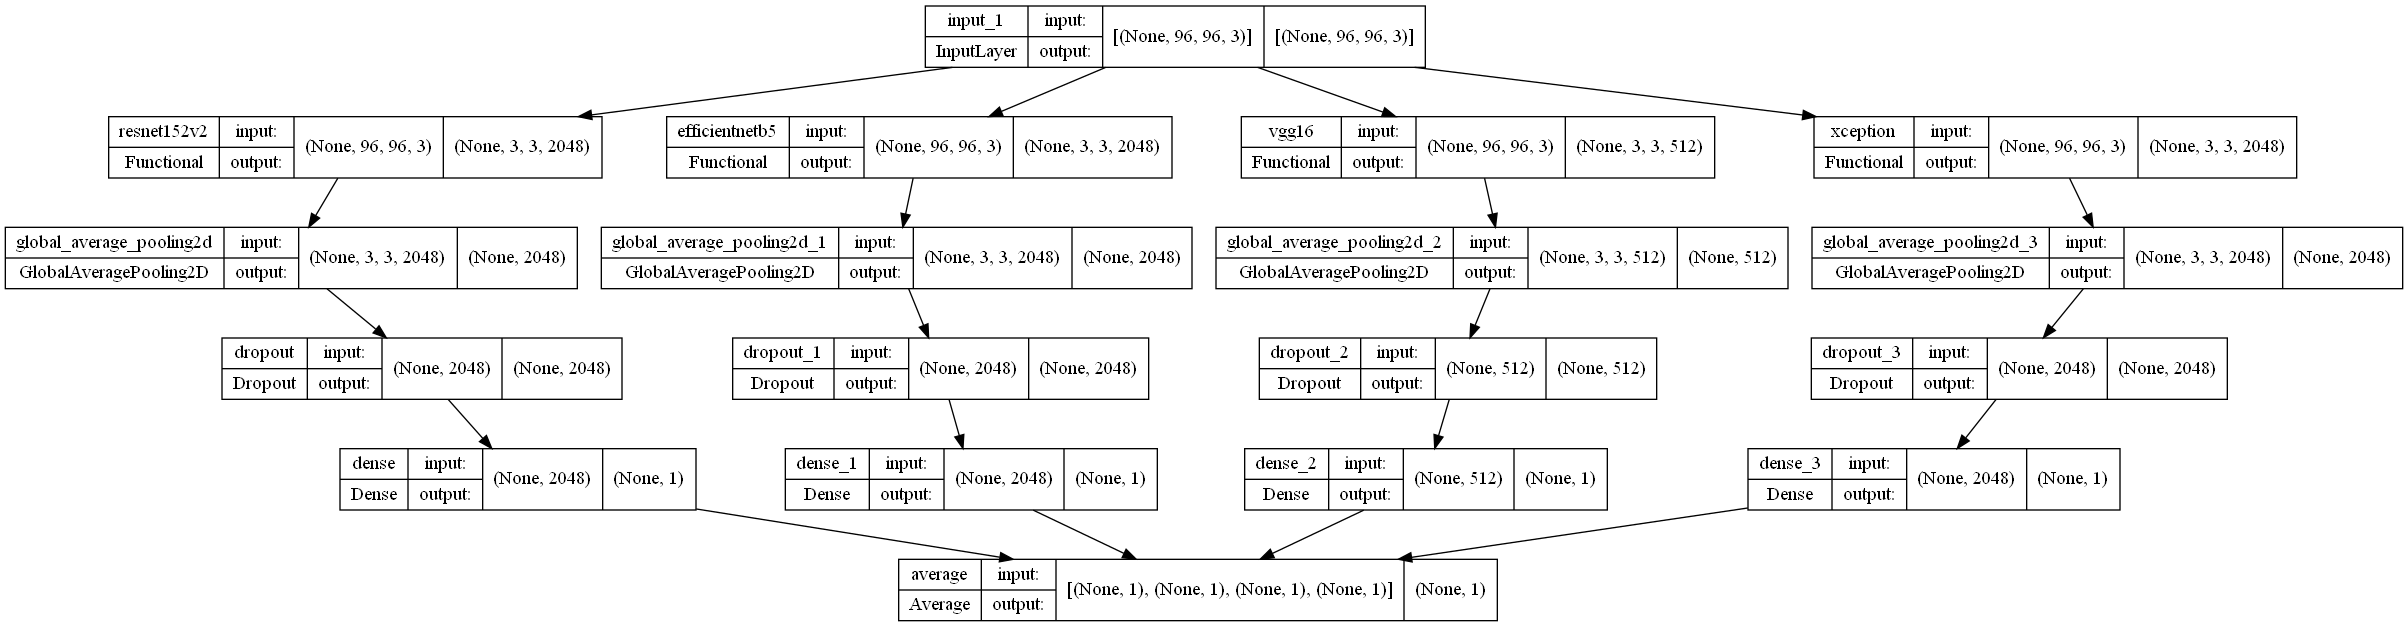

In [9]:
plot_model(ensemble_average_model, to_file='network_average_ensemble.png', show_shapes=True, show_layer_names=True)

#### saving the model

In [17]:
ensemble_average_model_name = 'Ensemble_average_model'
ensemble_average_model_filepath = ensemble_average_model_name + '.json'
ensemble_average_weights_filepath = ensemble_average_model_name + '_weights.hdf5'

ensemble_average_model_json = ensemble_average_model.to_json() # serialize model to JSON
with open(ensemble_average_model_filepath, 'w') as json_file:
    json_file.write(ensemble_average_model_json)
    
# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(ensemble_average_weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', ensemble_average_model_name))
callbacks_list = [checkpoint, tensorboard]

#### Training the model

In [15]:
train_steps = train_gen.n//train_gen.batch_size//20
val_steps = val_gen.n//val_gen.batch_size//20

history = ensemble_average_model.fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_steps=val_steps,validation_data=val_gen,
                    epochs=10,
                    callbacks=callbacks_list, shuffle=False)


#### Metrics

In [ ]:
import matplotlib.pyplot as plt

ensemble_average_model = tf.keras.models.load_model(ensemble_average_weights_filepath)
y_pred = ensemble_average_model.predict(val_gen, verbose=1).ravel()
y_true = val_gen.labels

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ensemble_average_model')
plt.legend(loc='best')
plt.show()

## Create voting ensemble

In [24]:
models = [pretrained_ResNet, pretrained_EfficientNet, pretrained_VGG, pretrained_Xception]
model_outputs = [Dense(1, activation = 'sigmoid')(Dropout(0.5)(GlobalAveragePooling2D()(model(model_input)))) for model in models]
models = [Model(model_input, model_outputs[i]) for i in range(len(model_outputs))]
for m in models:
    m.compile(SGD(lr=0.001, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

model_results = []
for i in range(len(models)):
    models[i].fit_generator(train_gen, steps_per_epoch=train_steps,
                    validation_steps=val_steps,validation_data=val_gen,
                    epochs=10, shuffle=False)
    model_results.append(models[i])

C:\Users\20192236\AppData\Local\Temp/ipykernel_19612/4089109777.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  models[i].fit_generator(train_gen, steps_per_epoch=train_steps,


225/225 [==============================] - 500s 2s/step - loss: 0.5582 - accuracy: 0.7121 - val_loss: 0.3546 - val_accuracy: 0.8413


In [43]:
# Predict labels with models
labels = []
for m in model_results:
    predicts = np.argmax(m.predict(val_gen), axis=1)
    labels.append(predicts)
    
# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))

In [44]:
import scipy
labels = scipy.stats.mode(labels, axis=0)[0]
labels

array([[0, 0, 0, 0]], dtype=int64)

#### metrics

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, labels)
from sklearn.metrics import auc
auc = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for ensemble_voting_model')
plt.legend(loc='best')
plt.show()